In [838]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import random
import os

# Paramètres globaux

In [839]:
RAW_REP = "raw"
OUTPUT_FOLDER = "processed"
N = 5000 # taille de la population
CODES_NAF = [el for el in range(1,99) if el not in (1,2,3,45,47,55,56,97,98,99)]
TYPE_DE_ZONE = ["urbaine", "urbaine", "rurale"]
AGE_TOP = 42
JOURS_MOYEN_DANS_UN_MOIS = 30.4
COEFF_RECTIFICATEUR = 1.3 # à modifier en fonction de la moyenne générale de rae
RAE_MOY = ((0.5 * 3.5 + 0.4 * 9 + 0.1 * 18) * JOURS_MOYEN_DANS_UN_MOIS) / COEFF_RECTIFICATEUR
CSP_DICT = {"Ouvrier": 1.4,
            "Employé": 1.2,
            "Technicien Maîtrise": 1,
            "Cadre": 0.8,
            "Cadre supérieur": 0.6}

# Génération des ID et des fausses identités

In [742]:
noms_df = pd.read_csv(os.path.join(RAW_REP, "patronymes.csv"))
prenoms_df = pd.read_csv(os.path.join(RAW_REP, "prenoms.csv"), sep=';', encoding='1252')

In [743]:
f_french_names = prenoms_df[prenoms_df['03_langage'].astype(str).str.contains("french") & (prenoms_df['02_genre'] == 'f')]
m_french_names = prenoms_df[prenoms_df['03_langage'].astype(str).str.contains("french") & (prenoms_df['02_genre'] == 'm')]

In [744]:
m_prenoms = [x[0].upper() + x[1:] for x in m_french_names['01_prenom'].to_list() if len(x) < 50]
f_prenoms = [x[0].upper() + x[1:] for x in f_french_names['01_prenom'].to_list() if len(x) < 50]

In [745]:
noms = noms_df['patronyme'].to_list()

In [746]:
def generate_birthday(start_date: tuple=(1948, 1, 1), end_date: tuple=(1985, 1, 1)):

    start_date, end_date = dt.date(*start_date), dt.date(*end_date)
    return start_date + dt.timedelta(days=random.randrange((end_date - start_date).days))

In [748]:
def birthday():
    if random.randint(1,10) > 4: return generate_birthday((1962, 1, 1), (1982, 1, 1))
    else: return generate_birthday((1982, 1, 1), (2002, 1, 1))

In [747]:
def generate_prenom(genre: str, prenoms_male: list=m_prenoms, prenoms_female: list=f_prenoms) -> str:
    
    if genre =='h': return random.choice(prenoms_male)
    else: return random.choice(prenoms_female)

In [750]:
def naf(): return random.choice(CODES_NAF)

In [751]:
def zone(): return random.choice(TYPE_DE_ZONE)

In [791]:
# 5% entre 0 et 100 salariés
# 30% dans des entreprises entre 100 et 250
# 15% entre 250 et 500
# 25% entre 500 et 1000
# 25% plus de 1000
def entreprise():
    x = random.randint(1, 100)
    if x <= 5: return random.randint(0, 100)
    elif x <= 35: return random.randint(100, 250)
    elif x <= 50: return random.randint(251, 500)
    elif x <= 75: return random.randint(501, 1000)
    else : return random.randint(1001, 2000)

# Coeffecients

## Coefficients

In [874]:
def calcul_duree_rae(age, csp, nbr_salaries, zone):
    
    # age
    x = np.random.normal(abs(1 - (age / AGE_TOP)) + 0.7, 0.3)
    age_coef = x if x > 0 else 0.7
    
    # csp
    csp_coef = CSP_DICT[csp]
    
    # taille entreprise
    nbr_salaries_coef = 1 - (0.001 * x) + 0.4 if x < 1000 else 0.4
    
    # zone urbaine ou rurale
    zone_coef = 1.2 if zone == "rurale" else 0.8
    
    coef = age_coef * csp_coef * nbr_salaries_coef * zone_coef
    
    return coef if coef < 3 else 3 # on évite les outlies
    
    # Pour afficher le détail du calcul par individu
    return {'duree_rae' : age_coef * csp_coef * nbr_salaries_coef * zone_coef,
            'age_coef' : age_coef,
            'csp_coef' : csp_coef,
            'nbr_salaries_coeff' : nbr_salaries_coef,
            'zone': zone_coef}
    

# Création du Dataframe

In [875]:
# ID
df = pd.DataFrame(range(1,N)).rename(columns={0:"id"})

In [876]:
# Genre
df['genre'] = df.apply(lambda x: random.choice(['h','f']), axis=1)

In [877]:
# Prénom et Nom
df['prenom'] = df.apply(lambda x: generate_prenom(x['genre']), axis=1)
df['nom'] = df.apply(lambda x: random.choice(noms), axis=1)

In [878]:
# Date de naissance
df['date_de_naissance'] = df.apply(lambda x : birthday(), axis=1)

In [879]:
# Age
df['age'] = ((pd.Timestamp('now').date() - df['date_de_naissance'])/ np.timedelta64(1, 'Y')).astype(int)

In [880]:
# CSP
df['csp'] = df.apply(lambda x : random.choice(list(CSP_DICT.keys())), axis=1)

In [881]:
# Nbr d'employés dans l'entreprise
df['nbr_de_salaries'] = df.apply(lambda x: entreprise(), axis=1)

In [882]:
# Code naf
df['code_naf'] = df.apply(lambda x: naf(), axis=1)

In [883]:
# Zone urbaine ou rurale
df['zone'] = df.apply(lambda x: zone(), axis=1)

In [884]:
# Coef global pour chaque individu
df['coef'] = df.apply(lambda x: calcul_duree_rae(x['age'], x['csp'], x['nbr_de_salaries'], x['zone']), axis=1)

In [885]:
# Durée du rae
df['duree_rae'] = (df['coef'] * RAE_MOY).astype(int)

## Stats et vérifications

In [890]:
df.head(10)

,id,genre,prenom,nom,date_de_naissance,age,csp,nbr_de_salaries,code_naf,zone,coef,duree_rae
0,1,h,Mathis,VIANA FUZA,1962-03-28,60,Cadre supérieur,1899,27,rurale,0.940748,157
1,2,f,Sylvie,EL YOUNANI,1965-09-06,56,Cadre,423,94,urbaine,0.994021,166
2,3,f,Hortense,GROS,1978-05-05,44,Cadre,242,10,urbaine,0.688066,115
3,4,f,Inès,RAULT VERHAERHE,1978-02-13,44,Cadre supérieur,263,17,rurale,0.659418,110
4,5,h,Désiré,GUGGIARI,1980-10-12,41,Technicien Maîtrise,223,31,rurale,0.019161,3
5,6,h,Marin,DAUZONNE,2001-06-14,20,Technicien Maîtrise,1415,62,urbaine,1.023556,171
6,7,f,Anastasie,GIOMO,1997-07-15,24,Technicien Maîtrise,197,40,urbaine,0.969677,162
7,8,h,Adolphe,JEYASANKAR,1968-09-06,53,Cadre,996,67,urbaine,0.284302,47
8,9,h,Maxime,TLUCEK,1995-03-06,27,Technicien Maîtrise,272,65,rurale,2.200580,367
9,10,f,Felicienne,MOUREDA,1995-08-10,26,Cadre supérieur,162,67,rurale,0.927465,155


In [886]:
df['coef'].min()

0.019161414048686095

In [887]:
df['coef'].max()

3.0

In [888]:
df['coef'].mean()

1.2159853633925446

In [889]:
df['duree_rae'].describe()

count    4999.000000
mean      202.814363
std       102.438877
min         3.000000
25%       128.000000
50%       186.000000
75%       262.000000
max       501.000000
Name: duree_rae, dtype: float64

In [891]:
df['duree_rae'].groupby(df['csp']).mean()

csp
Cadre                  161.610619
Cadre supérieur        122.710819
Employé                241.756312
Ouvrier                282.160194
Technicien Maîtrise    206.544677
Name: duree_rae, dtype: float64

<AxesSubplot:xlabel='age'>

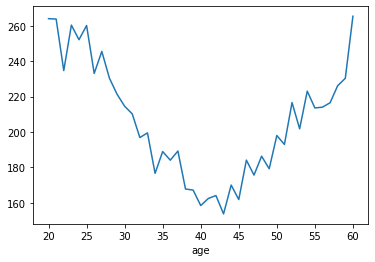

In [892]:
df['duree_rae'].groupby(df['age']).mean().plot()

In [893]:
df['duree_rae'].groupby(df['zone']).mean()

zone
rurale     257.797374
urbaine    173.146905
Name: duree_rae, dtype: float64

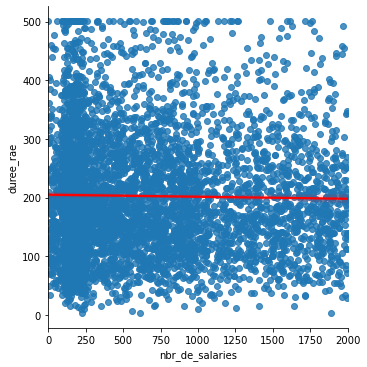

In [894]:
sns.lmplot(x='nbr_de_salaries',
           y='duree_rae',
           data=df,
           fit_reg=True,
           line_kws={'color': 'red'});

## Pourquoi ne peut-on pas voir l'effet de l'entreprise ?

In [896]:
toto = lambda x : 1 - (0.001 * x) + 0.4 if x < 1000 else 0.4

In [897]:
a = []
for i in range(1,1000): a.append(toto(i))

<AxesSubplot:>

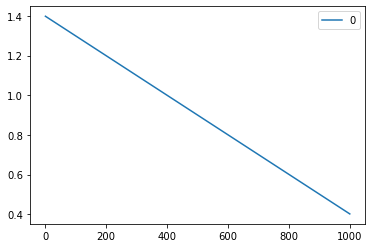

In [898]:
# pourtant la fonction donne les résultats attendus...
pd.DataFrame.from_dict({k:v for k,v in zip(range(1,1000), a)}, orient='index').plot()